# 👋 Welcome to Conformal Prediction with PyTorch

PyTorch is a popular deep learning library that facilitates the implementation and use of state-of-the-art learning models. In this tutorial, we will demonstrate how to make PyTorch fully interoperable with PUNCC by leveraging the skorch library.

By the end of this tutorial, you will be able to apply conformal prediction to PyTorch models for uncertainty quantification in various tasks, such as regression and classification.

-------
Another solution involves using the [IdPredictor](https://deel-ai.github.io/puncc/prediction.html#prediction.IdPredictor), which serves as a placeholder for any modele, even those accessible only through API calls. The predictions of the underlying model(s) should be directly passed to puncc for the conformal prediction process, enabling flexible integration with a wide range of models and APIs.

-------

**Table of contents**

- [⚙️ Setup](#cr-setup)
- [💾 Dataset](#cr-data)
- [🔮 Prediction Model](#cr-pm)
- [⏸️ Conformal Prediction with SplitCP](#cr-splitcp)
- [🤞 Conformal Prediction with CV+](#cr-cvplus)
- [〽️ Conformal Prediction with CQR](#cr-cqr)

**Links**
- [<img src="https://github.githubassets.com/images/icons/emoji/octocat.png" width=20> Github](https://github.com/deel-ai/puncc)
- [📘 Documentation](https://deel-ai.github.io/puncc/index.html)

### ⚙️ Setup  <a class="anchor" id="cr-setup"></a>

First, ensure we have the necessary libraries installed. You can install them if needed using pip:

In [1]:
!pip install torch skorch puncc

We import some modules and implement the function `evaluate_cp` that evaluates a conformal predictor on a test dataset by predicting intervals for the test inputs and computing the average width and coverage of these predictions, using the specified risk level $\alpha$.

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
from deel.puncc.metrics import regression_sharpness, regression_mean_coverage

warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)


# Function to evaluate the sharpness and coverage of a conformal prediction model
def evaluate_cp(X_test, y_test, model_cp, alpha):
    """
    Evaluate the performance of a model using conformal prediction.

    Parameters:
    - X_test : The input features for the test set.
    - y_test : The true labels for the test set.
    - model_cp : The conformal prediction model.
    - alpha : The maximum risk level for the prediction intervals.

    Returns:
    - sharpness : The average width of the prediction intervals.
    - coverage : The average coverage of the prediction intervals.
    """
    y_pred, y_pred_lower, y_pred_upper = model_cp.predict(X_test, alpha=alpha)
    sharpness = regression_sharpness(y_pred_lower, y_pred_upper)
    coverage = regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
    return sharpness, coverage

### 💾 Dataset <a class="anchor" id="cr-data"></a>

We consider a synthetic 1D heteroskedastic dataset, where the variance of the noise increases with the value of the input feature.

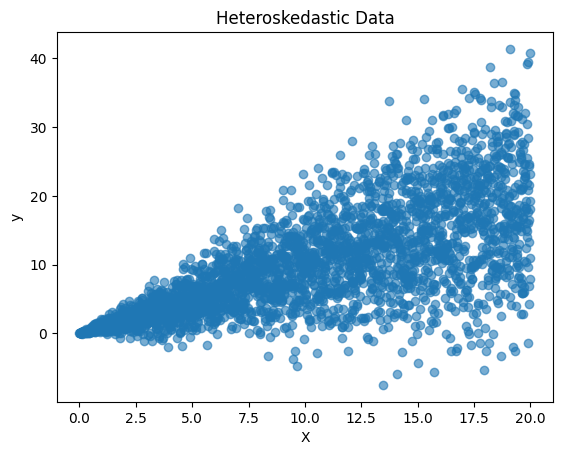

In [3]:
from sklearn.model_selection import train_test_split

# Generate synthetic 1D heteroskedastic data
n_samples = 3000
X = np.linspace(0, 20, n_samples).reshape(-1, 1)
y = X.squeeze() + np.random.randn(n_samples) * X.squeeze() * 0.5

# cast data to dtype float32
X = X.astype(np.float32)
y = y.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

# Plot the generated data to visualize heteroskedasticity
plt.scatter(X, y, alpha=0.6)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Heteroskedastic Data")
plt.show()

By construction, data are independent and identically distributed (i.i.d). We fullfill the prerequisites to apply conformal prediction 👏 !

### 🔮 Prediction Model <a class="anchor" id="cr-pm"></a>

We will define a simple neural network using PyTorch.

In [4]:
import torch.nn as nn
import torch.nn.functional as F


# Define a simple neural network for regression
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        x = self.linear(x)
        return x

⚠️ PyTorch API is not directly interoperable with puncc, because the fit and predict methods are not exposed. Therefore, we rely on Skorch, a library that provides a high-level interface for PyTorch, making it compatible with scikit-learn.

Skorch enables us to use the `NeuralNetRegressor` class (or `NeuralNetClassifier` for classification) as a wrapper around the PyTorch class definition (not an instantiated object). This wrapper allows us to easily specify various learning and optimization parameters, thereby facilitating the integration of PyTorch models into the scikit-learn ecosystem.

In [5]:
from skorch import NeuralNetRegressor

# Wrap the neural network in a scikit-learn compatible regressor
model = NeuralNetRegressor(
    module=RegressionNN,
    criterion=nn.MSELoss,
    optimizer=torch.optim.RMSprop,
    max_epochs=40,
    lr=0.005,
    device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=0,
)

There exist different conformal prediction methods that are tailored for specific cases and needs. In each method, the underlying model(s) to be conformalized are wrapped by puncc to guarantee compliance with its framework. Such wrappers are provided by puncc and are summarized in the table below. 
<br/><br/>
<div align='center'>

| Conformal Prediction Method | Model Wrapper         |
|-----------------------------|-----------------------|
| SplitCP                     | [`BasePredictor`](https://deel-ai.github.io/puncc/prediction.html#prediction.BasePredictor) |
| CVplus                      | [`BasePredictor`](https://deel-ai.github.io/puncc/prediction.html#prediction.BasePredictor)        |
| LocallyAdaptiveCP           | [`MeanVarPredictor`](https://deel-ai.github.io/puncc/prediction.html#prediction.MeanVarPredictor)      |
| EnbPI                       | [`BasePredictor`](https://deel-ai.github.io/puncc/prediction.html#prediction.BasePredictor)        |
| CQR                         | [`DualPredictor`](https://deel-ai.github.io/puncc/prediction.html#prediction.DualPredictor)        |
| APS or RAPS  (classification)               | [`BasePredictor`](https://deel-ai.github.io/puncc/prediction.html#prediction.BasePredictor) |
<caption>
Table 1: Model Wrappers for Different Conformal Prediction Methods in PUNCC
</caption>

</div>

<br/>

*📓 Note: puncc also enables to create fully custom [Predictor](https://deel-ai.github.io/puncc/api.html#predictor)(s). To know more about the puncc's API, check [this tutorial](https://github.com/deel-ai/puncc/blob/main/docs/api_intro.ipynb) <sub> [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1d06qQweM1X1eSrCnixA_MLEZil1vXewj) </sub>.*

In the following sections, we will explore various methods for quantifying uncertainty using conformal prediction, specifically focusing on Split Conformal Prediction (SplitCP), Conformal Cross-Validation Plus (CV+), and Conformalized Quantile Regression (CQR).

### ⏸️ Conformal Prediction with SplitCP <a class="anchor" id="cr-splitcp"></a>

The first approach we will use to conformalize our model is Split Conformal Prediction (SplitCP). SplitCP generates constant-length prediction intervals that provide a specified coverage probability $1-\alpha$, such that $\alpha$ is the maximum risk level. It works by splitting the data into two sets: a proper training (fit) set to train the model and a calibration set to calibrate the prediction intervals ensuring the desired coverage level. 

In accordance with *Table 1*, let's first wrap our model using `BasePredictor`:

In [6]:
from deel.puncc.api.prediction import BasePredictor

base_predictor = BasePredictor(model, is_trained=False)

2024-06-28 15:18:04.905657: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 15:18:04.905688: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 15:18:04.905709: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-28 15:18:04.911131: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-28 15:18:05.770396: W tensorflow/compiler/

Now we can to initialise and fit the `SplitCP` conformal predictor: 

In [7]:
from deel.puncc.regression import SplitCP

# Wrap the base predictor in a split conformal predictor
splitcp = SplitCP(
    base_predictor, train=True, random_state=0
)  # train=True to fit the split conformal predictor

# Fit the split conformal predictor:
# puncc will fit the base predictor on a fraction 'fit_ratio' of the training data and
# compute nonconformity scores on the remaining fraction
splitcp.fit(
    X=X_train,
    y=y_train,
    fit_ratio=0.5,
)

Finally, let's evaluate the performance of the prediction intervals (coverage and width) for a risk level $\alpha = 10\%$. Additionally, we will plot the prediction intervals to visually assess their performance.

Average prediction intervals width (sharpness): 20.562
Average coverage: 0.899


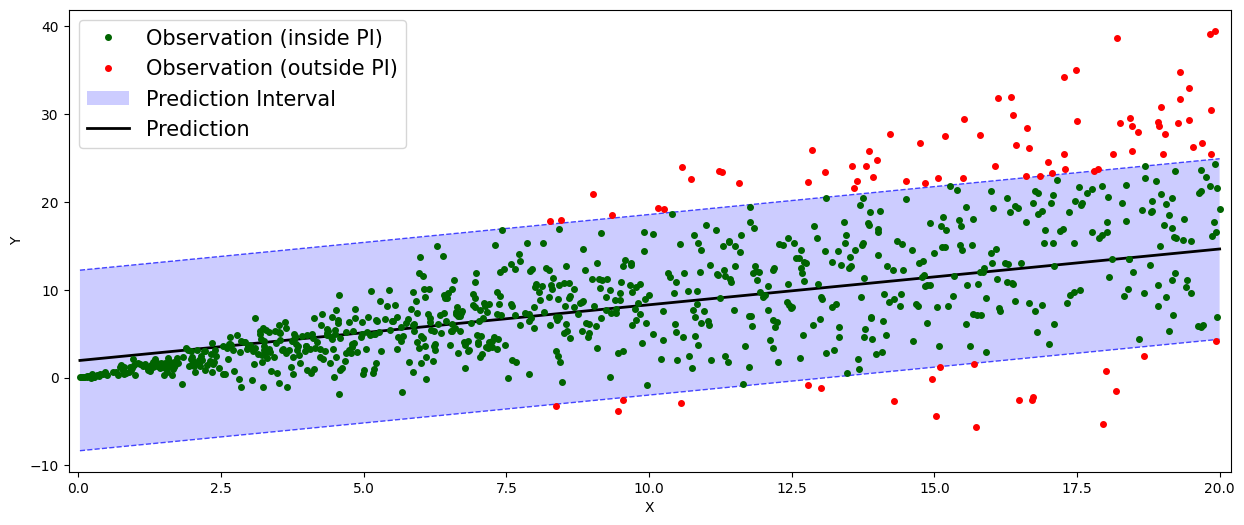

In [8]:
from deel.puncc.plotting import plot_prediction_intervals

# Maximum allowed error rate
alpha = 0.1

# Compute prediction intervals and metrics on the test set
y_pred, y_pred_lower, y_pred_upper = splitcp.predict(X_test, alpha=alpha)
sharpness, coverage = evaluate_cp(X_test, y_test, splitcp, alpha)
print(f"Average prediction intervals width (sharpness): {sharpness:.3f}")
print(f"Average coverage: {coverage:.3f}")

# Plot the prediction intervals
plot_prediction_intervals(
    y_true=y_test,
    y_pred_lower=y_pred_lower,
    y_pred_upper=y_pred_upper,
    y_pred=y_pred,
    X=X_test[:, 0],
)
plt.show()

### 🤞 Conformal Prediction with CV+ <a class="anchor" id="cr-cvplus"></a>

Let's reiterate the procedure using Conformal Cross-Validation Plus (CV+). CV+ extends the concept of split conformal prediction by integrating it with cross-validation. This combination enhances both the reliability and efficiency of the predictive intervals, overcoming limitations associated with a fixed proper training and calibration split.

We will again use the `BasePredictor` instance defined earlier.

Average prediction intervals width (sharpness): 21.615
Average coverage: 0.913


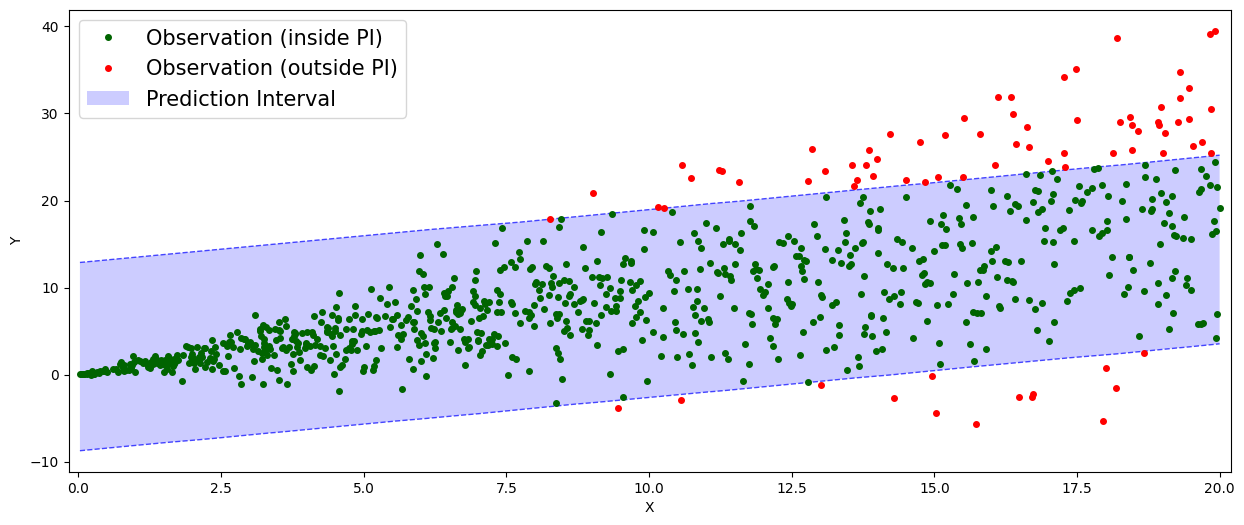

In [9]:
from deel.puncc.regression import CVPlus

# Wrap the base predictor in a split conformal predictor
cvplus = CVPlus(base_predictor, K=5, random_state=0)

# Fit the split conformal predictor:
# puncc will fit the base predictor on a fraction 'fit_ratio' of the training data and
# compute nonconformity scores on the remaining fraction
cvplus.fit(X=X_train, y=y_train)

# Compute prediction intervals and metrics on the test set
y_pred, y_pred_lower, y_pred_upper = cvplus.predict(X_test, alpha=alpha)
sharpness, coverage = evaluate_cp(X_test, y_test, cvplus, alpha)
print(f"Average prediction intervals width (sharpness): {sharpness:.3f}")
print(f"Average coverage: {coverage:.3f}")

# Plot the prediction intervals
plot_prediction_intervals(
    y_true=y_test,
    y_pred_lower=y_pred_lower,
    y_pred_upper=y_pred_upper,
    y_pred=y_pred,
    X=X_test[:, 0],
)
plt.show()

### 〽️ Conformal Prediction with CQR <a class="anchor" id="cr-cqr"></a>

Let's now consider Conformalized Quantile Regression (CQR). CQR extends traditional quantile regression by incorporating conformal prediction techniques, allowing us to construct predictive intervals with state-of-the-art performance and guaranteed coverage (under data exchangeability).

To do so, we need to modify our model to perform quantile regression. This is easily done by setting the loss as pinball loss. 

In [10]:
# Define a custom loss function for quantile regression
class PinballLoss(nn.Module):
    def __init__(self, quantile):
        super(PinballLoss, self).__init__()
        self.quantile = quantile

    def forward(self, y_pred, y_true):
        errors = y_true - y_pred
        loss = torch.max((self.quantile - 1) * errors, self.quantile * errors)
        return torch.mean(loss)


# Define a simple neural network for upper quantile regression
upper_quantile_model = NeuralNetRegressor(
    module=RegressionNN,
    criterion=PinballLoss(1 - alpha / 2),
    optimizer=torch.optim.RMSprop,
    max_epochs=40,
    lr=0.005,
    device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=0,
)

# Define a simple neural network for lower quantile regression
lower_quantile_model = NeuralNetRegressor(
    module=RegressionNN,
    criterion=PinballLoss(alpha / 2),
    optimizer=torch.optim.RMSprop,
    max_epochs=40,
    lr=0.005,
    device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=0,
)

To showcase the capabilities of PUNCC, we will fit the models first and then provide them to PUNCC for calibration. This approach allows PUNCC to directly conformalize pretrained models without the need to retrain them. However, it is necessary to set aside a calibration dataset specifically for the calibration process.


*📓 Note: to delegate the training to puncc, use a similar approach as the previous SplitCP and CV+ examples.*

In [11]:
# Split the training data into proper training (fit) set and calibration set
X_fit, X_calib, y_fit, y_calib = train_test_split(
    X_train, y_train, test_size=0.5, random_state=0
)

# Fit the upper and lower quantile models
_ = upper_quantile_model.fit(X_fit, y_fit)
_ = lower_quantile_model.fit(X_fit, y_fit)

Average prediction intervals width (sharpness): 17.547
Average coverage: 0.900


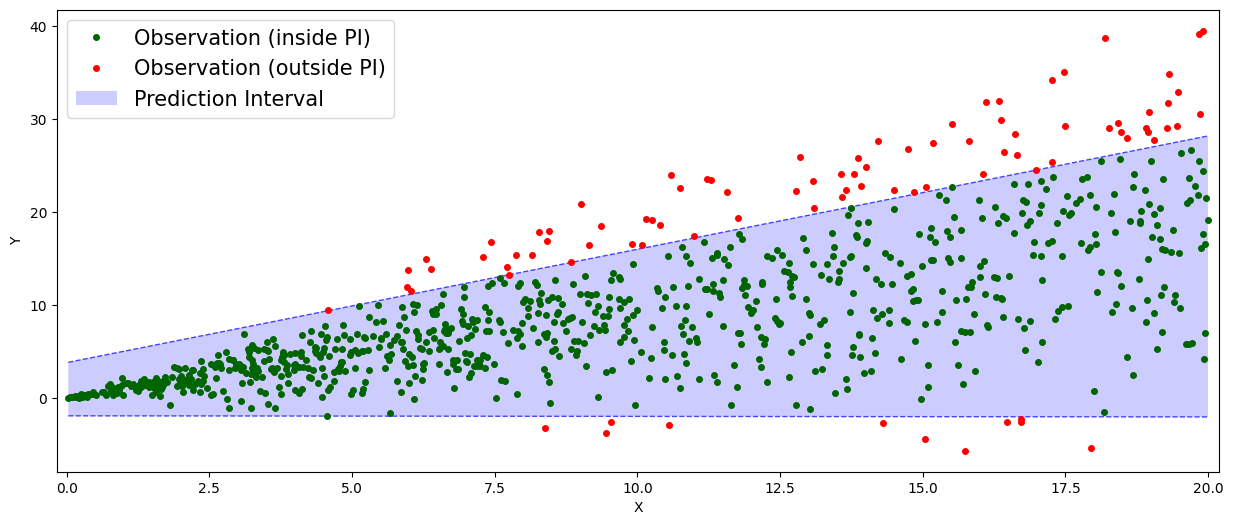

In [12]:
from deel.puncc.api.prediction import DualPredictor
from deel.puncc.regression import CQR

# Wrap the upper and lower quantile models in a dual predictor
dualpredictor = DualPredictor(
    [lower_quantile_model, upper_quantile_model], is_trained=[True, True]
)

# Initialize the CQR conformal predictor
cqr = CQR(
    dualpredictor, train=False
)  # train=False to use the pre-trained dual predictor

# Compute nonconformity scores on the calibration set
cqr.fit(X_calib=X_calib, y_calib=y_calib)

# Compute prediction intervals and metrics on the test set
y_pred, y_pred_lower, y_pred_upper = cqr.predict(X_test, alpha=alpha)
sharpness, coverage = evaluate_cp(X_test, y_test, cqr, alpha)

print(f"Average prediction intervals width (sharpness): {sharpness:.3f}")
print(f"Average coverage: {coverage:.3f}")

# Plot the prediction intervals
plot_prediction_intervals(
    y_true=y_test,
    y_pred_lower=y_pred_lower,
    y_pred_upper=y_pred_upper,
    X=X_test[:, 0],
)
plt.show()

# 🎉 Congratulations
**You now know how to perform conformal prediction with PyTorch models !**

Keep in mind that using skorch is an efficient way to streamline your workflow. Alternatively, you can always use the [IdPredictor](https://deel-ai.github.io/puncc/prediction.html#prediction.IdPredictor) to directly provide predictions to puncc or define your own [Predictor](https://deel-ai.github.io/puncc/api.html#predictor) to meet your needs. Should you encounter any issues, we encourage you to open an [issue](https://github.com/deel-ai/puncc?tab=readme-ov-file#-contributing), and we will be glad to assist you.